In [1]:
import os
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from yellowbrick.regressor import PredictionError, ResidualsPlot
from feature_extraction import extract_features_from_images
from sklearn.cross_decomposition import PLSRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')

In [3]:

def handle_model_evaluate(true, predicted, title_column=""):

    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    mape = np.mean(np.abs((true - predicted) / true)) * 100

    return pd.DataFrame(
        {
            f"{title_column}": [mae, mse, rmse, mape, r2_square],
        },
        index=["MAE", "MSE", "RMSE", "MAPE", "R-squared"],
    )

    
def show_model_performance(model, X_train, y_train, X_test, y_test):
    
    train = handle_model_evaluate(y_train, model.predict(X_train), "Treino")
    test  = handle_model_evaluate(y_test, model.predict(X_test), "Teste")
    
    display(pd.concat([train, test], axis=1))
    
    
def run_all_algs(X_train, y_train, X_test, y_test):

    models = {
        "GradientBoostingRegressor": GradientBoostingRegressor(),
        # "AdaBoostRegressor": AdaBoostRegressor(),
        "LinearRegression": LinearRegression(),
        "LassoRegression": Lasso(),
        "RidgeRegression": Ridge(),
        "RandomForestRegressor": RandomForestRegressor(),
        # "ElasticNet": ElasticNet(),
        # "[RANSACRegressor]": RANSACRegressor(),
        # "[PLSRegression]": PLSRegression(n_components=2),
        "PCARegression": make_pipeline(PCA(n_components=2), LinearRegression()),
        "PolyRegression": make_pipeline(PolynomialFeatures(degree=3), Lasso()),
        # "XGBRegressor": XGBRegressor()
    }
    
    for name, model in models.items():

        model.fit(X_train, y_train)
        
        print("\n","\b"+name)
        
        show_model_performance(model,
                               X_train,
                               y_train,
                               X_test,
                               y_test)

        print("_" * 20)
    
def print_evaluate(true, predicted, title_column=""):  
    
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    mape = np.mean(np.abs((true - predicted) / true)) * 100
    
    print(pd.DataFrame({
        f"{title_column}": [
            mae, 
            mse, 
            rmse,
            mape,
            r2_square],
    },
        index=[
            "MAE",
            "MSE",
            "RMSE",
            "MAPE",
            "R-squared"
        ]))

    
def ApplyesKFoldV2(x, y, k=5):
    metrics = [
        "r2",
        "neg_mean_absolute_error",
        "neg_mean_squared_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"    
    ]
    
    kfold  = KFold(n_splits=k, shuffle=True, random_state=0)

    models = {
        "GradientBoostingRegressor": GradientBoostingRegressor(),
        # "AdaBoostRegressor": AdaBoostRegressor(),
        "LinearRegression": LinearRegression(),
        "LassoRegression": Lasso(),
        "RidgeRegression": Ridge(),
        "RandomForestRegressor": RandomForestRegressor(),
        # "ElasticNet": ElasticNet(),
        # "RANSACRegressor": RANSACRegressor(),
        # "PLSRegression": PLSRegression(n_components=2),
        "PCARegression": make_pipeline(PCA(n_components=2), LinearRegression()),
        "PolyRegression": make_pipeline(PolynomialFeatures(degree=2), Lasso()),
    }

    results = {}
    
    for name, model in models.items():
        results[name] = cross_validate(model, x, y, cv=kfold, scoring=metrics)
        
    for name, cv_results in results.items():
        print(f"[{name}]")
        display(pd.DataFrame({
            f"Média": [
                cv_results['test_r2'].mean(), 
                -cv_results['test_neg_mean_absolute_error'].mean(),
                -cv_results['test_neg_mean_squared_error'].mean(),
                -cv_results['test_neg_root_mean_squared_error'].mean(),
                -cv_results['test_neg_mean_absolute_percentage_error'].mean()
            ],
            "Desvio Padrão": [
                cv_results['test_r2'].std(),
                cv_results['test_neg_mean_absolute_error'].std(),
                cv_results['test_neg_mean_squared_error'].std(),
                cv_results['test_neg_root_mean_squared_error'].std(),
                cv_results['test_neg_mean_absolute_percentage_error'].std()
            ]
        },
            index=["R-squared", "MAE", "MSE", "RMSE", "MAPE"],
        ))


def apply_pca_reduce(data, n=None):
    
    scaler = StandardScaler()
    X = scaler.fit_transform(data)
    
    pca = PCA(n_components=data.shape[-1]).fit(X)
    
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    dim = np.argmax(cumsum >= 0.90) + 1
    
    print('Para preservar 90% da variance é necessário ' + str(dim))
        
    pca_refit = PCA(n_components=n if n else dim).fit(X)
    print('Ratio: ', pca_refit.explained_variance_ratio_)
    
    return pca_refit.transform(X)

def corr_view(df, w=8, h=6):
    corrmat = df.corr()

    _, ax = plt.subplots(figsize=(w, h))

    sns.heatmap(corrmat, linewidths=5, annot=True);
    
    plt.show()
    
    return corrmat

## Extraindo Features das imagens mascaras

In [4]:
def load_dataset(base_path):
    
    *_, base_path_last = base_path.split("/")
    features_file_name = f"{base_path_last}_features.csv"
    
    if not os.path.isfile(features_file_name):
        extract_features_from_images(
            images_arr=[],
            images_path=f"{base_path}/masks",
            output_file_name=features_file_name,
            resize_shape=(224, 224))
    
    weights = pd.read_csv(f"{base_path}/annotations.csv")
    features = pd.read_csv(features_file_name)

    weights.index = weights.img
    features.index = features.label

    weights = weights.drop('img', axis=1)
    features = features.drop('label', axis=1)
    
    data = pd.concat([weights, features],
                     axis=1,
                     ignore_index=False, 
                     verify_integrity=True)

    data = data.reset_index()
    
    return data



In [5]:
data = load_dataset("data/coletas/combined")

In [6]:
f"{data.weight.sum() // 1000} " + "kg"

'105.0 kg'

In [7]:
# data.weight /= 1000

In [8]:
enc = LabelEncoder()

In [9]:
data.specie = enc.fit_transform(data.specie.values)

In [10]:
def load_unet_dataset(df):
    
    weights = df[["weight", "length", "specie", "width"]]
    weights.index = df["index"]

    features_file_name = "features_from_unet_predictions.csv"
    features = pd.read_csv(features_file_name)
    
    features.index = features.label

    features = features.drop('label', axis=1)
    
    data = pd.concat([weights, features],
                     axis=1,
                     ignore_index=False, 
                     verify_integrity=True)

    data = data.reset_index()
    
    return data

### Ajustando Features Extraídas da U-net

In [11]:
_, X_test = train_test_split(data, test_size=0.3, random_state=0)
unet_testing_features = load_unet_dataset(X_test)

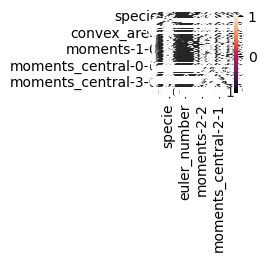

In [12]:
corrmat = corr_view(data, w=1, h=1)

In [13]:
features_names = list(dict(corrmat[corrmat.weight > 0.85].weight).keys())
features_names.append("specie")

In [14]:
data[features_names].head()

,weight,length,area,bbox_area,convex_area,equivalent_diameter,filled_area,major_axis_length,moments-0-0,moments-0-1,...,moments-2-1,moments-2-2,moments-2-3,moments_central-0-0,moments_central-0-2,moments_central-2-0,moments_central-2-2,perimeter,feret_diameter_max,specie
0,220.0,22.0,5867,8908,6372,86.429719,5867,122.598160,5867.0,344885.0,...,4.695134e+08,3.385144e+10,2.780223e+12,5867.0,5.510758e+06,1.470126e+06,7.711683e+08,340.048773,132.230859,3
1,545.0,26.0,10098,15272,10689,113.389474,10098,154.971729,10098.0,818043.0,...,2.222528e+09,2.201669e+11,2.427110e+13,10098.0,1.513501e+07,4.568750e+06,3.687127e+09,438.374675,166.364059,4
2,1025.0,31.0,13583,20580,14173,131.508223,13583,180.579492,13583.0,1285297.0,...,3.716828e+09,4.027404e+11,4.892637e+13,13583.0,2.755749e+07,8.335128e+06,9.660429e+09,500.114790,196.918765,0
3,740.0,37.0,8521,12864,9204,104.159849,8521,183.209467,8521.0,791315.0,...,1.111224e+09,1.270943e+11,1.647843e+13,8521.0,1.787565e+07,1.987899e+06,2.195729e+09,459.948268,192.210822,2
4,475.0,24.0,8184,11907,8614,102.079344,8184,138.020198,8184.0,587517.0,...,1.239091e+09,1.098955e+11,1.083366e+13,8184.0,9.715353e+06,3.038349e+06,2.008774e+09,380.776695,147.275253,4


In [15]:
unet_testing_features = unet_testing_features[features_names]

In [16]:
y = data.weight
X = data[features_names].drop(labels=['weight'], axis=1)
l = data['index']

In [17]:
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X.values, 
                                                                             y.values,
                                                                             l.values.tolist(),
                                                                             test_size=0.3, 
                                                                             random_state=0)

Unet_y_test = unet_testing_features.weight
unet_testing_features = unet_testing_features[features_names].drop(labels=['weight'], axis=1)

In [18]:
len(X_train), len(X_test)

(171, 74)

In [19]:
scaler = StandardScaler()

X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
Unet_X_test_scaled = scaler.transform(unet_testing_features.values)

# Prevendo para as máscaras geradas pela a unet - Sem normalização

In [26]:
run_all_algs(X_train, 
             y_train,
             X_test,
             y_test)


GradientBoostingRegressor


,Treino,Teste
MAE,5.753149,34.618445
MSE,53.400895,7108.305776
RMSE,7.307592,84.310769
MAPE,6.286146,8.043995
R-squared,0.999181,0.877678


____________________

LinearRegression


,Treino,Teste
MAE,23.974582,41.854334
MSE,962.880129,8170.057059
RMSE,31.030310,90.388368
MAPE,37.276645,13.512083
R-squared,0.985241,0.859406


____________________

LassoRegression


,Treino,Teste
MAE,26.431473,39.656571
MSE,1171.437241,8451.399781
RMSE,34.226265,91.931495
MAPE,27.699546,13.043333
R-squared,0.982044,0.854565


____________________

RidgeRegression


,Treino,Teste
MAE,23.950637,41.683038
MSE,962.984248,8140.760631
RMSE,31.031987,90.226164
MAPE,36.381970,13.413555
R-squared,0.985239,0.859911


____________________

RandomForestRegressor


,Treino,Teste
MAE,11.310737,35.603135
MSE,381.744587,6778.256631
RMSE,19.538285,82.330168
MAPE,54.313172,7.797324
R-squared,0.994149,0.883357


____________________

PCARegression


,Treino,Teste
MAE,53.294235,69.551406
MSE,5604.668222,13437.109407
RMSE,74.864332,115.918546
MAPE,249.648657,22.293332
R-squared,0.914090,0.768769


____________________

PolyRegression


,Treino,Teste
MAE,14.071769,31.924466
MSE,324.874632,5085.567821
RMSE,18.024279,71.313167
MAPE,20.140633,7.897775
R-squared,0.995020,0.912486


____________________


# Prevendo os pesos para as márcas previstas pela unet | Normalizado

In [21]:
run_all_algs(X_train_scaled, 
             y_train,
             Unet_X_test_scaled,
             y_test)


GradientBoostingRegressor


,Treino,Teste
MAE,5.753149,41.138786
MSE,53.400895,7331.734797
RMSE,7.307592,85.625550
MAPE,6.286146,10.032335
R-squared,0.999181,0.873833


____________________

LinearRegression


,Treino,Teste
MAE,23.975293,59.529593
MSE,962.880039,9437.755647
RMSE,31.030308,97.148112
MAPE,37.311182,19.038821
R-squared,0.985241,0.837591


____________________

LassoRegression


,Treino,Teste
MAE,31.956953,55.031958
MSE,1804.489268,8736.306219
RMSE,42.479280,93.468210
MAPE,21.587117,17.528081
R-squared,0.972340,0.849662


____________________

RidgeRegression


,Treino,Teste
MAE,28.597508,55.451863
MSE,1448.371179,8942.838852
RMSE,38.057472,94.566584
MAPE,15.823772,17.916019
R-squared,0.977799,0.846108


____________________

RandomForestRegressor


,Treino,Teste
MAE,11.456047,43.001946
MSE,356.194738,7651.059743
RMSE,18.873122,87.470336
MAPE,48.031462,10.051445
R-squared,0.994540,0.868338


____________________

PCARegression


,Treino,Teste
MAE,37.241035,54.234824
MSE,2470.607808,9209.688890
RMSE,49.705209,95.967124
MAPE,92.887716,17.147199
R-squared,0.962130,0.841516


____________________

PolyRegression


,Treino,Teste
MAE,19.584782,49.269408
MSE,622.533633,10944.823711
RMSE,24.950624,104.617511
MAPE,28.739563,19.989758
R-squared,0.990458,0.811657


____________________


## Polinomial Features -  Qualquer  regressor pode ser adicionado ao pipeline

#### Obs: Não executar transformação de features


Foi selecionado um dos modelos de regressão que performaram bem para visualizar dua predições

In [27]:
model = make_pipeline(PolynomialFeatures(degree=3), Lasso(10)).fit(X_train, y_train)

print_evaluate(y_train, model.predict(X_train), "Treino")
print_evaluate(y_test, model.predict(unet_testing_features.values), "Teste")

               Treino
MAE         14.115978
MSE        323.940446
RMSE        17.998346
MAPE        17.541936
R-squared    0.995035
                 Teste
MAE          39.016092
MSE        5582.740155
RMSE         74.717737
MAPE          9.595564
R-squared     0.903930


# Figuras para explicar o modelo

In [28]:
model = make_pipeline(PolynomialFeatures(degree=3), Lasso(10))

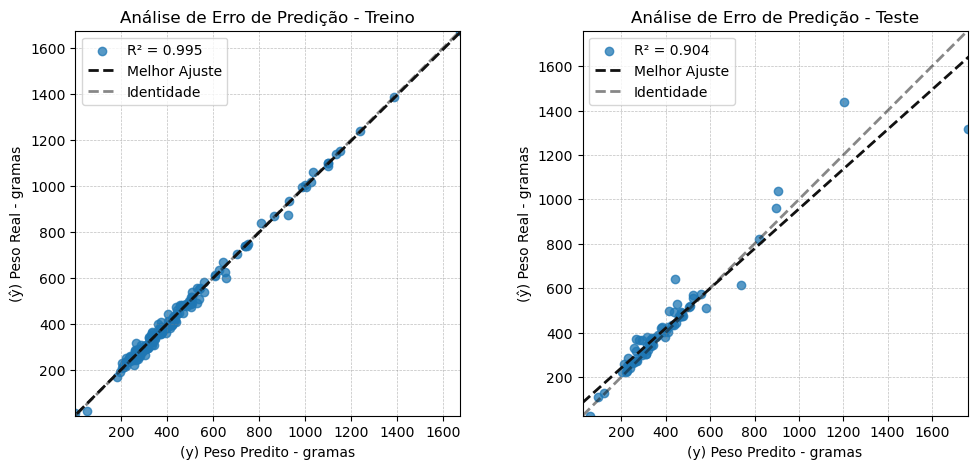

In [29]:
# fig, ax = plt.subplots(figsize=(6, 10))
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))


def make_plot(ax, model, x, y, title):

    model = PredictionError(model, ax=ax).fit(X_train, y_train)
    score = model.score(x, y)
    model.finalize()

    ax.set_xlabel("(y) Peso Predito - gramas")
    ax.set_ylabel("(ŷ) Peso Real - gramas")
    ax.legend([f"R² = {round(score, 3)}", "Melhor Ajuste", "Identidade"])
    ax.set_title(f"Análise de Erro de Predição - {title}")

    ax.grid(color='gray', 
            linestyle='--',
            linewidth=0.5,
            alpha=0.5)
    
    return score

test_score = make_plot(axs[1], 
                       model,
                       unet_testing_features.values,
                       y_test, 
                       title="Teste")

train_score = make_plot(axs[0],
                        model,
                        X_train,
                        y_train, 
                        title="Treino")

plt.savefig("analise_erro_predicao.pdf")

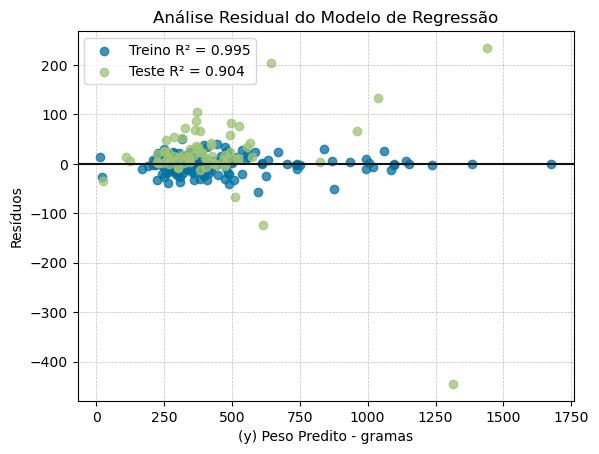

In [30]:
visualizer = ResidualsPlot(model, hist=False).fit(X_train, y_train)

test_score = visualizer.score(unet_testing_features.values, y_test)

visualizer.finalize()

visualizer.ax.legend([f"Treino R² = {round(train_score, 3)}", f"Teste R² = {round(test_score, 3)}"], loc="upper left")

visualizer.ax.set_xlabel("(y) Peso Predito - gramas")
visualizer.ax.set_ylabel("Resíduos")
visualizer.ax.set_title("Análise Residual do Modelo de Regressão")
visualizer.ax.grid(color='gray', 
                   linestyle='--',
                   linewidth=0.5,
                   alpha=0.5)

plt.savefig("analise_residuos_predicao.pdf")